In [145]:
import matplotlib.pyplot as plt
import pdb
import tensorflow as tf
from adversarial_robustness_toolbox_main.art.estimators.classification import KerasClassifier
from adversarial_robustness_toolbox_main.art.attacks.evasion.projected_gradient_descent import ProjectedGradientDescentTensorFlowV2

import math
from matplotlib import pylab as P
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import defaultdict

import os
import os.path as osp
import numpy as np
import pickle
import io
import PIL.Image
import scipy
import time
import glob
import random
import cv2

import keras
from keras import applications
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage.interpolation import rotate
import numpy as np

loss_object = tf.keras.losses.CategoricalCrossentropy() # loss function 정의


SyntaxError: invalid syntax (<ipython-input-145-18672c102d8f>, line 4)

In [2]:
# 0 is female , 1 is male
# 모델 가져오기
MODEL_HDF5_age = './agegender_age_vgg16_imdb.hdf5'
MODEL_HDF5_gender = './agegender_gender_vgg16_imdb.hdf5'
keras_age_model = load_model(MODEL_HDF5_age)
keras_gender_model = load_model(MODEL_HDF5_gender)
keras_age_model.summary()
keras_gender_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [3]:
# 이미지 렌덤하게 중간 날리는거 왜쓰는지 모르겠음...

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c

        return input_img
    return eraser

In [4]:
# data 가져와서 labeling하기
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10,
    #preprocessing_function=get_random_eraser(v_l=0, v_h=255)
)
SQ_IMAGE_SIZE = 227
VGG_IMAGE_SIZE = 224
BATCH_SIZE = 1
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

age_train_generator = train_datagen.flow_from_directory(
    #DATASET_ROOT_PATH+'dataset/agegender_'+DATASET_NAME+'/annotations/'+ANNOTATIONS+'/train',
    'C:\\Users\\guembo\\adversarial-patch-master\\adversarial-patch-master\\YoloKerasFaceDetection-master\\dataset\\agegender_imdb\\annotations\\age\\train',
    target_size=(VGG_IMAGE_SIZE, VGG_IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

age_validation_generator = test_datagen.flow_from_directory(
    'C:\\Users\\guembo\\adversarial-patch-master\\adversarial-patch-master\\YoloKerasFaceDetection-master\\dataset\\agegender_imdb\\annotations\\age\\validation',
    target_size=(VGG_IMAGE_SIZE, VGG_IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

gender_train_generator = train_datagen.flow_from_directory(
    #DATASET_ROOT_PATH+'dataset/agegender_'+DATASET_NAME+'/annotations/'+ANNOTATIONS+'/train',
    'C:\\Users\\guembo\\adversarial-patch-master\\adversarial-patch-master\\YoloKerasFaceDetection-master\\dataset\\agegender_imdb\\annotations\\gender\\train',
    target_size=(VGG_IMAGE_SIZE, VGG_IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

gender_validation_generator = test_datagen.flow_from_directory(
    'C:\\Users\\guembo\\adversarial-patch-master\\adversarial-patch-master\\YoloKerasFaceDetection-master\\dataset\\agegender_imdb\\annotations\\gender\\validation',
    target_size=(VGG_IMAGE_SIZE, VGG_IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

age_training_data_n = len(age_train_generator.filenames)
age_validation_data_n = len(age_validation_generator.filenames)
gender_training_data_n = len(gender_train_generator.filenames)
gender_validation_data_n = len(gender_validation_generator.filenames)
print("age Training data count : "+str(age_training_data_n))
print("age Validation data count : "+str(age_validation_data_n))
print("gender Training data count : "+str(gender_training_data_n))
print("gender Validation data count : "+str(gender_validation_data_n))

Found 128854 images belonging to 8 classes.
Found 42998 images belonging to 8 classes.
Found 128854 images belonging to 2 classes.
Found 42998 images belonging to 2 classes.
age Training data count : 128854
age Validation data count : 42998
gender Training data count : 128854
gender Validation data count : 42998


(1, 2)
2
2
0
0


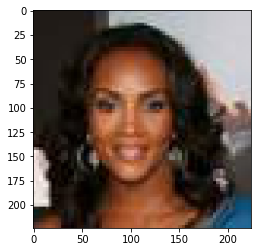

In [86]:
# 그냥 한번 뽑아 봣음
'''
for i in enumerate(range(2)):
    img, label = age_validation_generator.next()
    print(img)
    #data = np.array(img,dtype=np.float32)
    a = create_adversarial_pattern(img,label)
    #print(a)
    #print(loss)
    print("----------------------")    
    plt.imshow(img[0])    
''' 
for i in enumerate(range(1)): # vgg : 1,224,224,3 sq~~ : 1,227,227,3
    age_img, age_label = age_validation_generator.next()
    gender_img, gender_label = gender_validation_generator.next()
    print(gender_label.shape)
    #img = tf.convert_to_tensor(img)
    #img = np.transpose(img,(0,3,2,1))
    #print(img.shape)
    print(keras_age_model(age_img).numpy().argmax())
    print(age_label.argmax())
    #gender_img = gender_img.reshape(224,224,3)
    print(keras_gender_model(gender_img).numpy().argmax())
    print(gender_label.argmax())
    plt.imshow(gender_img[0])
    

In [103]:
#초기 patch 모양
image_size = 299
patch_size = 0.05
def init_patch_circle(image_size, patch_size):
    image_size = image_size**2
    noise_size = int(image_size*patch_size)
    radius = int(math.sqrt(noise_size/math.pi))
    patch = np.zeros((1, 3, radius*2, radius*2))    
    for i in range(3):
        a = np.zeros((radius*2, radius*2))    
        cx, cy = radius, radius # The center of circle 
        y, x = np.ogrid[-radius: radius, -radius: radius]
        index = x**2 + y**2 <= radius**2
        a[cy-radius:cy+radius, cx-radius:cx+radius][index] = np.random.rand()
        idx = np.flatnonzero((a == 0).all((1)))
        a = np.delete(a, idx, axis=0)
        patch[0][i] = np.delete(a, idx, axis=1)
    return patch, patch.shape

def init_patch_square(image_size, patch_size):
    # get mask
    image_size = image_size**2
    noise_size = image_size*patch_size
    noise_dim = int(noise_size**(0.5))
    patch = np.random.rand(1,3,noise_dim,noise_dim)
    return patch, patch.shape

In [7]:
def submatrix(arr):
    x, y = np.nonzero(arr)
    # Using the smallest and largest x and y indices of nonzero elements, 
    # we can find the desired rectangular bounds.  
    # And don't forget to add 1 to the top bound to avoid the fencepost problem.
    return arr[x.min():x.max()+1, y.min():y.max()+1]

In [8]:
def circle_transform(patch, data_shape, patch_shape, image_size): 
    # get dummy image 
    x = np.zeros(data_shape)
   
    # get shape
    m_size = patch_shape[-1]
    
    for i in range(x.shape[0]):

        # random rotation
        rot = np.random.choice(360)
        for j in range(patch[i].shape[0]): # patch[i].shape[0] = 3
            patch[i][j] = rotate(patch[i][j], angle=rot, reshape=False)
        
        # random location
        random_x = np.random.choice(image_size)
        if random_x + m_size > x.shape[-1]:
            while random_x + m_size > x.shape[-1]:
                random_x = np.random.choice(image_size)
        random_y = np.random.choice(image_size)
        if random_y + m_size > x.shape[-1]:
            while random_y + m_size > x.shape[-1]:
                random_y = np.random.choice(image_size)
       
        # apply patch to dummy image  
        x[i][0][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = patch[i][0]
        x[i][1][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = patch[i][1]
        x[i][2][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = patch[i][2]
    
    mask = np.copy(x)
    mask[mask != 0] = 1.0
    
    return x, mask, patch.shape

patch, patch_shape = init_patch_circle(image_size, patch_size)
data_shape = (1,3,224,224)
patch, mask,patch_shape  = circle_transform(patch, data_shape, patch_shape, image_size)

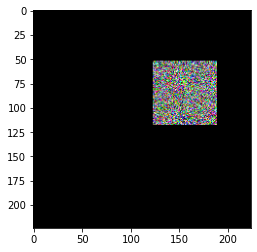

In [104]:
def square_transform(patch, data_shape, patch_shape, image_size):
    # get dummy image 
    x = np.zeros(data_shape)
    #print(x.shape)
    # get shape
    m_size = patch_shape[-1] # shape의 크기 구하기 ex) 3,60,60, => 60
    #print(m_size)
    for i in range(x.shape[0]):

        # random rotation
        rot = np.random.choice(4)
        for j in range(patch[i].shape[0]):
            patch[i][j] = np.rot90(patch[i][j], rot)
        
        # random location
        random_x = np.random.choice(image_size)
        if random_x + m_size > x.shape[-1]:
            while random_x + m_size > x.shape[-1]:
                random_x = np.random.choice(image_size)
        random_y = np.random.choice(image_size)
        if random_y + m_size > x.shape[-1]:
            while random_y + m_size > x.shape[-1]:
                random_y = np.random.choice(image_size)
       
        # apply patch to dummy image  
        x[i][0][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = patch[i][0]
        x[i][1][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = patch[i][1]
        x[i][2][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = patch[i][2]
    mask = np.copy(x)
    mask[mask != 0] = 1.0 # 0이 아닌 값은 1로 
    return x, mask

patch, patch_shape = init_patch_square(image_size, patch_size)
data_shape = (1,3,224,224)
patch, mask  = square_transform(patch, data_shape, patch_shape, image_size)
'''
a = patch* mask
a = a.reshape(-1)
print(np.sort(a)[::-1][13000])
patch[patch != 0] = 1.0
print((patch == mask).all())
print(patch,mask)
'''
a = np.transpose(patch,(0,2,3,1)) #1,3,227,227 ->  1, 227,227,3
plt.imshow(a[0])

In [120]:
patch_type = 'circle'
age_target = 5
age_target_label = tf.one_hot(age_target,8)
age_target_label = tf.reshape(age_target_label, (1,8))

gender_target = 0 # 여자가 0 남자가 1
gender_target_label = tf.one_hot(gender_target,2)
gender_target_label = tf.reshape(gender_target_label,(1,2))
print(age_target_label)
print(gender_target_label)
def train(epoch, patch, patch_shape):
    success = 0
    total = 0
    recover_time = 0
    for i in enumerate(age_train_generator):
        
        age_data, age_label = age_validation_generator.next() # 1,227,227,3
        gender_data, gender_label = gender_validation_generator.next()
        
        age_prediction = keras_age_model.predict(age_data).argmax()
        gender_prediction = keras_gender_model.predict(gender_data).argmax()
        
        # only computer adversarial examples on examples that are originally classified correctly         
        if ((age_prediction != age_label.argmax()) and (gender_prediction != gender_label.argmax())): # 예측이랑 label이랑 다르면 계산안함
            continue
     
        total += 1
        
        # transform path
        data_shape = (1,3,224,224) # patch size는 1,3,~,~ 형태
        if patch_type == 'circle':
            patch, mask, patch_shape = circle_transform(patch, data_shape, patch_shape, image_size)
        elif patch_type == 'square':
            patch, mask  = square_transform(patch, data_shape, patch_shape, image_size)
        #patch = tf.convert_to_tensor(patch,dtype=tf.float32)
        #mask = tf.convert_to_tensor(mask,dtype=tf.float32)
        #if opt.cuda:
        #    patch, mask = patch.cuda(), mask.cuda()
        
        adv_x, mask, patch = attack(age_data, gender_data, patch, mask) # 여기까지 수정함
        
        adv_label = netClassifier(adv_x).data.max(1)[1][0]
        ori_label = labels.data[0]
        
        if adv_label == target:
            success += 1
      
            if plot_all == 1: 
                # plot source image
                vutils.save_image(data.data, "./%s/%d_%d_original.png" %(opt.outf, batch_idx, ori_label), normalize=True)
                
                # plot adversarial image
                vutils.save_image(adv_x.data, "./%s/%d_%d_adversarial.png" %(opt.outf, batch_idx, adv_label), normalize=True)
 
        masked_patch = torch.mul(mask, patch)
        patch = masked_patch.data.cpu().numpy()
        new_patch = np.zeros(patch_shape)
        for i in range(new_patch.shape[0]): 
            for j in range(new_patch.shape[1]): 
                new_patch[i][j] = submatrix(patch[i][j])
 
        patch = new_patch

        
    return patch

tf.Tensor([[0. 0. 0. 0. 0. 1. 0. 0.]], shape=(1, 8), dtype=float32)
tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)


In [95]:
# gender 학습 -> 73%에서 멈춤...
conf_target = 0.9 
max_count = 1000
def attack(age_x, gender_x,patch, mask):

    gender_x_out = tf.nn.softmax(keras_gender_model(gender_x)) # 1, 227,227,3 => 1,101
    gender_target_prob = gender_x_out[0][gender_target]
    
    patch = np.transpose(patch,(0,2,3,1)) # patch , mask => 1,227,227,3
    mask = np.transpose(mask,(0,2,3,1))
    
    adv_x = (1-mask)*gender_x + mask*patch # 원래 그림에 patch붙이기
    count = 0 
    
    #plt.imshow(adv_x[0])
    adv_x = tf.convert_to_tensor(adv_x,dtype=tf.float64)

    while conf_target > gender_target_prob: # 미분값 계산해서 빼주고 바뀐 patch+image랑 확률 비교해서 90% 될때까지 뺑뻉이
        count += 1                   # max_count까지 돌리기 
        
        
        with tf.GradientTape() as tape:
            tape.watch(adv_x)
            gender_prediction = keras_gender_model(adv_x) # 그거에 log_softmax ( 왜 log_softmax인지는 모름)
            
            loss = loss_object(gender_target_label, gender_prediction)
            
            #print("loss is : ",loss)
    
        gradient = tape.gradient(loss, adv_x) # adv_x와 loss간의 미분 계산
        #print(gradient[0][0][0][0])
   
        
        patch -= tf.sign(gradient)
        #patch -= gradient
       # print(patch)
        adv_x = ((1-mask)*gender_x + mask*patch)
        
        #print(adv_x)
        
        gender_out = tf.nn.softmax(keras_gender_model(adv_x))
        gender_target_prob = gender_out[0][gender_target]
        
        print(count, conf_target, gender_target_prob)  
        
        if count >= max_count:
            break
   
    return adv_x, mask, patch 
   

In [121]:
#age 학습 -> 28%에서 멈춤 ...
conf_target = 0.9
max_count = 1000
def attack(age_x, gender_x,patch, mask):

    age_x_out = tf.nn.softmax(keras_age_model(age_x)) # 1, 227,227,3 => 1,101
    age_target_prob = age_x_out[0][age_target]
    
    patch = np.transpose(patch,(0,2,3,1)) # patch , mask => 1,227,227,3
    mask = np.transpose(mask,(0,2,3,1))
    
    adv_x = (1-mask)*age_x + mask*patch # 원래 그림에 patch붙이기
    count = 0 
    
    #plt.imshow(adv_x[0])
    adv_x = tf.convert_to_tensor(adv_x,dtype=tf.float64)

    while conf_target > age_target_prob: # 미분값 계산해서 빼주고 바뀐 patch+image랑 확률 비교해서 90% 될때까지 뺑뻉이
        count += 1                   # max_count까지 돌리기 
        
        
        with tf.GradientTape() as tape:
            tape.watch(adv_x)
            age_prediction = keras_age_model(adv_x) # 그거에 log_softmax ( 왜 log_softmax인지는 모름)
            
            loss = loss_object(age_target_label, age_prediction)
            #loss = tf.keras.losses.categorical_crossentropy(age_target_label, age_prediction)
            
            #print("loss is : ",loss)
    
        gradient = tape.gradient(loss, adv_x) # adv_x와 loss간의 미분 계산
        #print(gradient[0][0][0][0])
   
        patch -= tf.sign(gradient)
            
        adv_x = ((1-mask)*age_x + mask*patch)
        #adv_x += tf.sign(gradient)       
        #adv_x = tf.clip_by_value(adv_x, -3, 3)
   
        age_out = tf.nn.softmax(keras_age_model(adv_x))
        age_target_prob = age_out[0][age_target]
        
        print(count, conf_target, age_target_prob)  
        
        if count >= max_count:
            plt.imshow(adv_x[0].numpy())
            break
   
    return adv_x, mask, patch 
   

In [122]:
patch, patch_shape = init_patch_circle(image_size, patch_size)
patch = train(1, patch, patch_shape)

1 0.9 tf.Tensor(0.13022208, shape=(), dtype=float32)
2 0.9 tf.Tensor(0.15435658, shape=(), dtype=float32)
3 0.9 tf.Tensor(0.16859889, shape=(), dtype=float32)
4 0.9 tf.Tensor(0.14324845, shape=(), dtype=float32)
5 0.9 tf.Tensor(0.20267464, shape=(), dtype=float32)
6 0.9 tf.Tensor(0.22350062, shape=(), dtype=float32)
7 0.9 tf.Tensor(0.19677883, shape=(), dtype=float32)
8 0.9 tf.Tensor(0.21842471, shape=(), dtype=float32)
9 0.9 tf.Tensor(0.25388905, shape=(), dtype=float32)
10 0.9 tf.Tensor(0.2585534, shape=(), dtype=float32)
11 0.9 tf.Tensor(0.23063506, shape=(), dtype=float32)
12 0.9 tf.Tensor(0.26447833, shape=(), dtype=float32)
13 0.9 tf.Tensor(0.27739364, shape=(), dtype=float32)
14 0.9 tf.Tensor(0.26712576, shape=(), dtype=float32)
15 0.9 tf.Tensor(0.27367344, shape=(), dtype=float32)
16 0.9 tf.Tensor(0.27777573, shape=(), dtype=float32)
17 0.9 tf.Tensor(0.2786089, shape=(), dtype=float32)
18 0.9 tf.Tensor(0.27855378, shape=(), dtype=float32)
19 0.9 tf.Tensor(0.2792262, shape=(), d

KeyboardInterrupt: 

In [ ]:
a = np.random.randn(2,10)
print(a)
log_softmax = tf.nn.log_softmax(a)
softmax = tf.nn.softmax(a)
print("log_softmax is : ",log_softmax)
print("softmax is :",softmax)
print(tf.reduce_sum(log_softmax),tf.reduce_sum(softmax,1))

In [ ]:
a = np.random.randn(2,3)
print("a is : ",a)
mask = np.array([[0,1,1],[1,0,1]])
print("mask is : ",mask)
patch = np.array([[-1.2415,0.0000000000000000124123,0.00000000000000000000000000061512],[0.72462,-0.51521,0.1351241243]])
#print("1-mask * a : ",(1-mask)*a)
print("mask * patch : ",mask*patch,tf.math.count_nonzero(mask*patch))
adv_x = (1-mask)*a + mask*patch # adv_x가 계산값이 항상 같음 ;;
adv_x2 = tf.multiply((1-mask),a) + tf.multiply(mask,patch)
#print("adv_x is : ",adv_x)
print(tf.math.count_nonzero(mask*patch),mask*patch)
patch -= np.random.randn(2,3)
print(patch)
print(tf.math.count_nonzero(mask*patch),mask*patch)

In [ ]:
a = np.random.randn(2,3)
print(a)
b = np.zeros((2,3))
print(a*b)